<a href="https://colab.research.google.com/github/nidharap/Notebooks/blob/master/IMDB_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook intends to fine-tune the RoBERTa architecture on the IMDB 50K movie reviews dataset.

##### Most of the code was inspired from https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 890kB 14.2MB/s 
     |████████████████████████████████| 1.1MB 17.4MB/s 
     |████████████████████████████████| 3.0MB 24.3MB/s 


In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.0.2


In [3]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import RobertaModel, RobertaTokenizer
import torch
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import time
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader
import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#we will load the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

#Dataset
### The dataset can be downloaded from multiple places , but I used this - https://www.kaggle.com/atulanandjha/imdb-50k-movie-reviews-test-your-bert

In [6]:
df = pd.read_csv("/content/drive/My Drive/Datasets/IMDBMovieReviews/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Datasets/IMDBMovieReviews/test.csv")
df['label_encoded'] = df['sentiment'].apply(lambda x: 0 if x=='neg' else 1)
df_test['label_encoded'] = df_test['sentiment'].apply(lambda x: 0 if x=='neg' else 1)
df['review_len'] = df['text'].apply(lambda x : len(x.split()))
class_names = ['neg', 'pos']

#remove html tags
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)
df_test['text'] = df_test['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

#separate the train set into train and val
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

df.shape, df_train.shape, df_val.shape, df_test.shape

((25000, 4), (20000, 4), (5000, 4), (25000, 3))

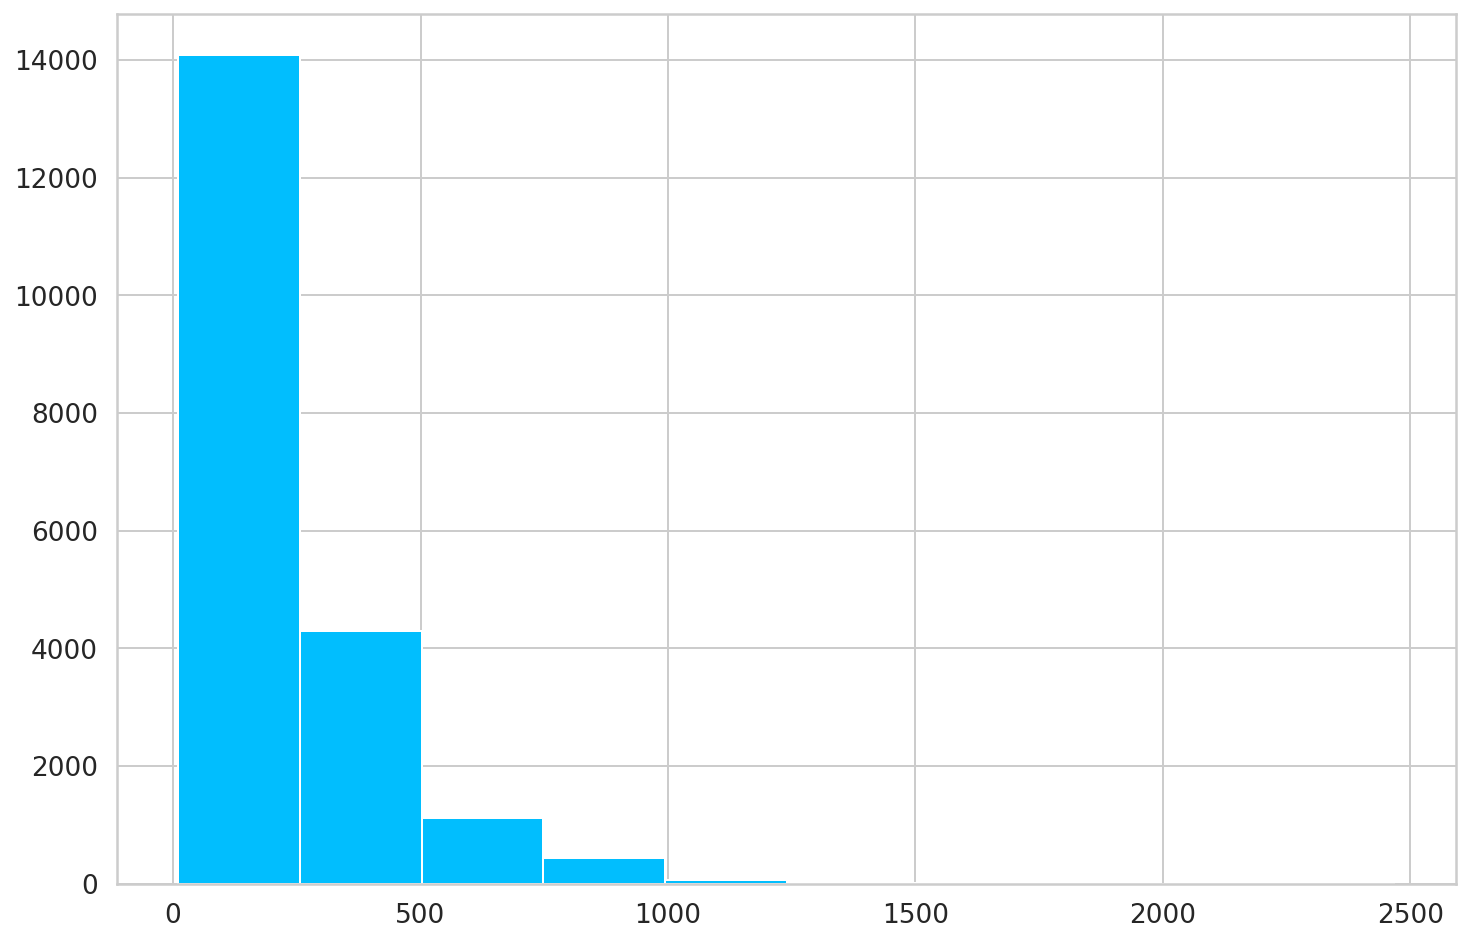

In [9]:
df_train['review_len'].hist()

In [10]:
PRE_TRAINED_MODEL_NAME = 'roberta-base' #'bert-base-cased'
MAX_LEN = 512     #for the most part, things are below 500, lets set it to max len possible in bert
MODEL_SAVE_NAME = "imdb_movie_large_roberta_state"
LOAD_PREV_MODEL = False     #set to True to load a trained model from local 

In [11]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
MAX_LEN = 512

In [15]:
class ReviewsDataset(Dataset):
  '''
  custom pytorch dataset class
  '''
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]


    encoding = self.tokenizer.encode_plus(
        review, 
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    #return the review and attention masks
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  '''
  create a data loader for the dataset
  '''
  ds = ReviewsDataset(
    reviews=df.text.to_numpy(),
    targets=df.label_encoded.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [17]:
#batch size is tricky . Larger batch size lead to memory issue on GPU
#I have a colab pro subscription that gives me larger memory and gpus, but for free versions,
#I suggest using batch size of 8. It will take longer run train with smaller batch sizes
BATCH_SIZE = 16    

#initialize data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
class SentimentClassifier(nn.Module):
  '''
  Wrapper class to add dropout and FC layer on top of the 
  pooled output provided by hugging face transformers
  '''
  def __init__(self, n_classes, bertmodel, dropout_p=0.3):
    super(SentimentClassifier, self).__init__()
    self.bert = bertmodel
    self.dropout = nn.Dropout(p=dropout_p)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.dropout(pooled_output)
    return self.out(output)

In [19]:
#init the model
model = SentimentClassifier(len(class_names), bertmodel=bert_model).to(device)

In [20]:
EPOCHS = 10

#adam w is a special version of Adam optimizer that transformers library provides
#https://huggingface.co/transformers/main_classes/optimizer_schedules.html

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) 
loss_fn = nn.CrossEntropyLoss().to(device)
print("len(train_data_loader): ", len(train_data_loader))
total_steps = len(train_data_loader) * EPOCHS
print("total_steps: ", total_steps)

#define LR scheduler
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

len(train_data_loader):  1250
total_steps:  12500


In [21]:
history = None
best_accuracy = None

In [23]:
if LOAD_PREV_MODEL and len(list(glob.glob("/content/drive/My Drive/Datasets/IMDBMovieReviews/{}*".format(MODEL_SAVE_NAME)))) > 0:
  #Load previous model to continue training
  state_file_name = sorted(list(glob.glob("/content/drive/My Drive/Datasets/IMDBMovieReviews/{}*".format(MODEL_SAVE_NAME))))[-1]
  print("Loading : {}".format(state_file_name))
  state = torch.load(state_file_name)
  print(state.keys())
  

  model.load_state_dict(state['model'])

  optimizer.load_state_dict(state['optimizer'])
  scheduler.load_state_dict(state['scheduler'])
  history = state['history']
  best_accuracy = state['history']

  EPOCHS = EPOCHS - state['epoch']-1
  state = None

Loading : /content/drive/My Drive/Datasets/IMDBMovieReviews/imdb_movie_large_roberta_state_3
dict_keys(['epoch', 'model', 'optimizer', 'scheduler', 'history', 'best_accuracy'])


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [24]:
torch.cuda.empty_cache()

In [25]:
def train_epoch(model, dataloader, lossfn, opt, device, schedulr , n_examples):
  model.train();
  losses = []
  correct_preds = 0

  for ind, d in enumerate(dataloader):
    if ind%100 == 0:
      print(f"iter#{ind}")
    input_ids = d["input_ids"].to(device)
    targets = d["targets"].to(device)
    attention_mask = d['attention_mask'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_values, max_indices = torch.max(outputs, dim=1)
    loss = lossfn(outputs, targets)
    correct_preds+=torch.sum(max_indices == targets)
    losses.append(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    opt.step()
    schedulr.step()
    opt.zero_grad()

  return correct_preds.double()/n_examples, np.mean(losses)

In [26]:
def eval_model(model, dataloader, lossfn, device , n_examples):
  model.eval();
  losses = []
  correct_preds = 0

  with torch.no_grad():
    for d in dataloader:
      input_ids = d["input_ids"].to(device)
      targets = d["targets"].to(device)
      attention_mask = d['attention_mask'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      max_values, max_indices = torch.max(outputs, dim=1)
      loss = lossfn(outputs, targets)
      correct_preds+=torch.sum(max_indices == targets)
      losses.append(loss.item())

  return correct_preds.double()/n_examples, np.mean(losses)

#Lets begin training

In [25]:
if history is None:
  history = defaultdict(list)
if best_accuracy is None:
  best_accuracy = 0


for epoch in range(EPOCHS):
  start_time = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  print("--- %s seconds ---" % (time.time() - start_time))

  #save only those models that do better on val
  if val_acc > best_accuracy:
    drive.mount('/content/drive')
    state = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'history': history,
    'best_accuracy': best_accuracy

    }
    torch.save(state, "/content/drive/My Drive/Datasets/IMDBMovieReviews/{}_{}".format(MODEL_SAVE_NAME, epoch))

    best_accuracy = val_acc

Epoch 1/10
----------
iter#0
iter#100
iter#200
iter#300
iter#400
iter#500
iter#600
iter#700
iter#800
iter#900
iter#1000
iter#1100
iter#1200
Train loss 0.26536205899715426 accuracy 0.9049
Val   loss 0.1769509918559283 accuracy 0.9326000000000001

--- 1152.3893358707428 seconds ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch 2/10
----------
iter#0
iter#100
iter#200
iter#300
iter#400
iter#500
iter#600
iter#700
iter#800
iter#900
iter#1000
iter#1100
iter#1200
Train loss 0.14671359480600804 accuracy 0.96045
Val   loss 0.277531427673448 accuracy 0.9322

--- 1152.06764626503 seconds ---
Epoch 3/10
----------
iter#0
iter#100
iter#200
iter#300
iter#400
iter#500
iter#600
iter#700
iter#800
iter#900
iter#1000
iter#1100
iter#1200
Train loss 0.08877174927648157 accuracy 0.9805
Val   loss 0.31664617552857893 accuracy 0.9386

--- 1151.8642163276672 seconds ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 4/10
----------
iter#0
iter#100
iter#200
iter#300
iter#400
iter#500
iter#600
iter#700
iter#800
iter#900
iter#1000
iter#1100
iter#1200
Train loss 0.056235692315129565 accuracy 0.98855
Val   loss 0.3184103596544179 accuracy 0.9416

--- 1151.4621181488037 seconds ---
Drive already mounted at /content/drive; to attempt to forcibly

Process Process-68:
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()
  File "/usr/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4e8e74a940>>
Traceback (mos

KeyboardInterrupt: ignored

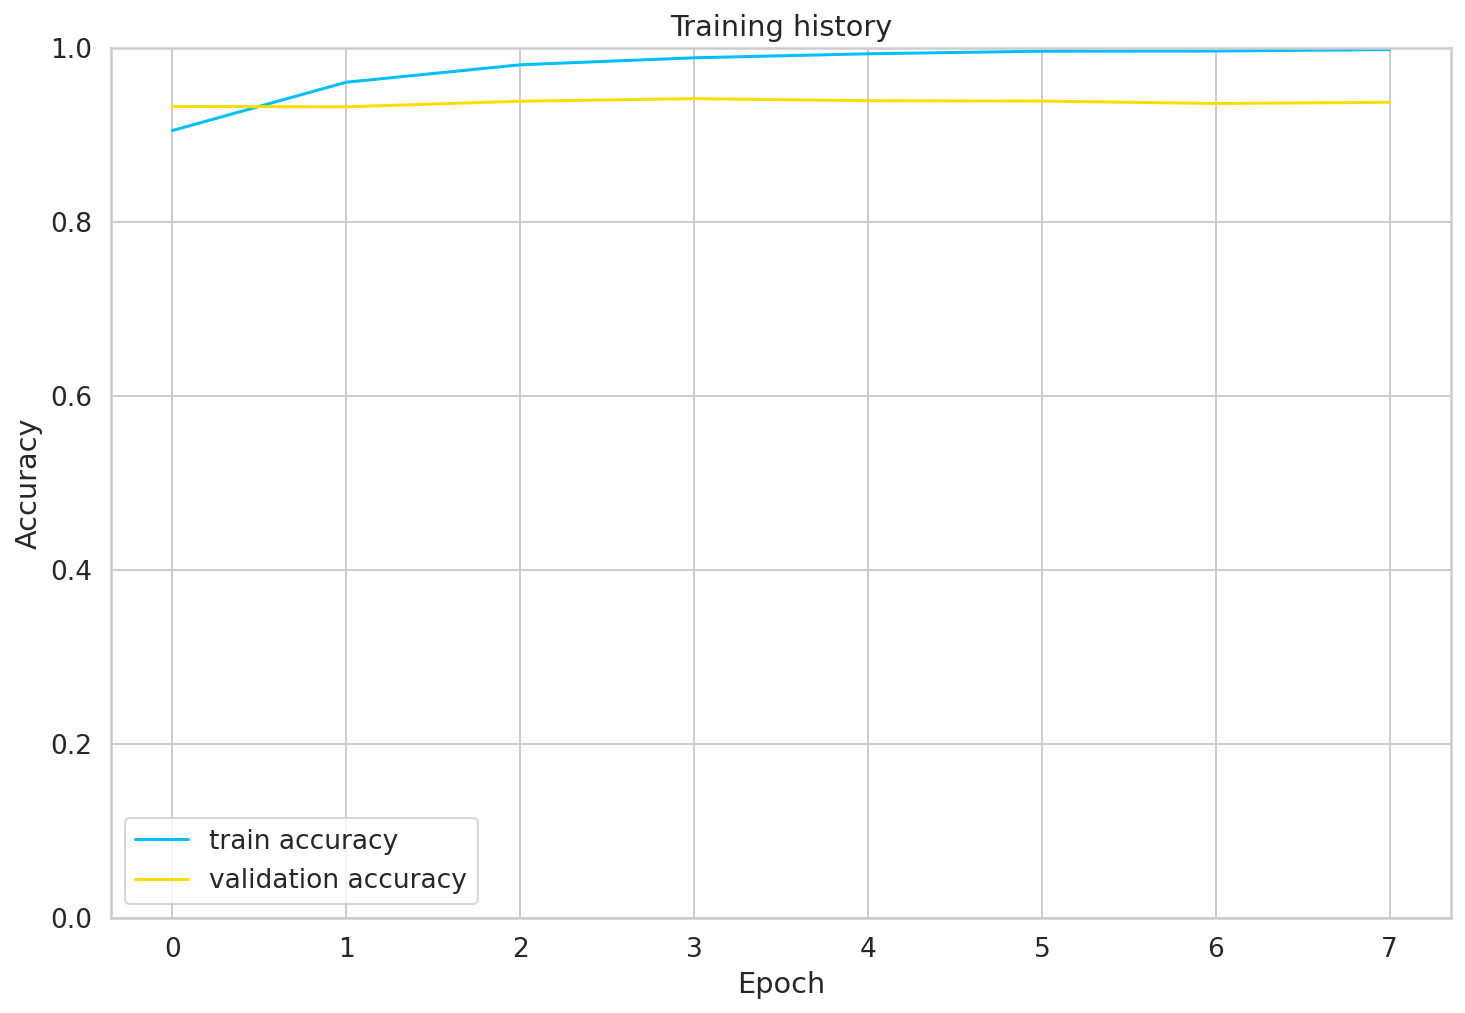

In [26]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [1]:
#Evaluate accuracy on test set (blind)
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: ignored

In [ ]:
def get_predictions(model, data_loader):
  # This is similar to the evaluation function, 
  #except that we're storing the text of the reviews and the predicted 
  #probabilities (by applying the softmax on the model outputs)
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

#Lets look at the confusion matrix on test

In [ ]:
#Get confusion matrix on test
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

#get preds from test set
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

#visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [30]:
#example to predict on one example
review_text = "Hated it with all my being. Worst movie ever. Mentally- scarred. Help me. It was that bad.TRUST ME!!!"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

model.eval();
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')